# Material Stream Identification System
Classify waste materials using SVM and k-NN with PCA

**Optimized for 85%+ accuracy**

## 1. Import Libraries

In [ ]:
import os
import glob
import random
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from skimage.feature import local_binary_pattern, hog

In [5]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
import joblib
import warnings
warnings.filterwarnings('ignore')

## 2. Configuration

In [7]:
# Dataset path
DATASET_PATH = './dataset'
MODELS_PATH = './models'

In [8]:
# Class names
CLASS_NAMES = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash', 'unknown']
print(CLASS_NAMES)

['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash', 'unknown']


In [9]:
# Create models folder
os.makedirs(MODELS_PATH, exist_ok=True)
print("Setup done!")

Setup done!


## 3. Load Images

In [10]:
# Function to load all images from folders
def read_images_from_all_folders(dataset_path):
    image_paths = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for ext in ("*.jpg", "*.jpeg", "*.png"):
                for img_path in glob.glob(os.path.join(folder_path, ext)):
                    image_paths.append((img_path, folder))
    
    images = []
    print(f"Loading {len(image_paths)} images...")
    for path, label in image_paths:
        try:
            img = Image.open(path).convert('RGB')
            images.append((path, img, label))
        except:
            pass
    print(f"Successfully loaded: {len(images)}")
    return images

In [11]:
# Load images
raw_images = read_images_from_all_folders(DATASET_PATH)

Loading 1960 images...
Successfully loaded: 1865


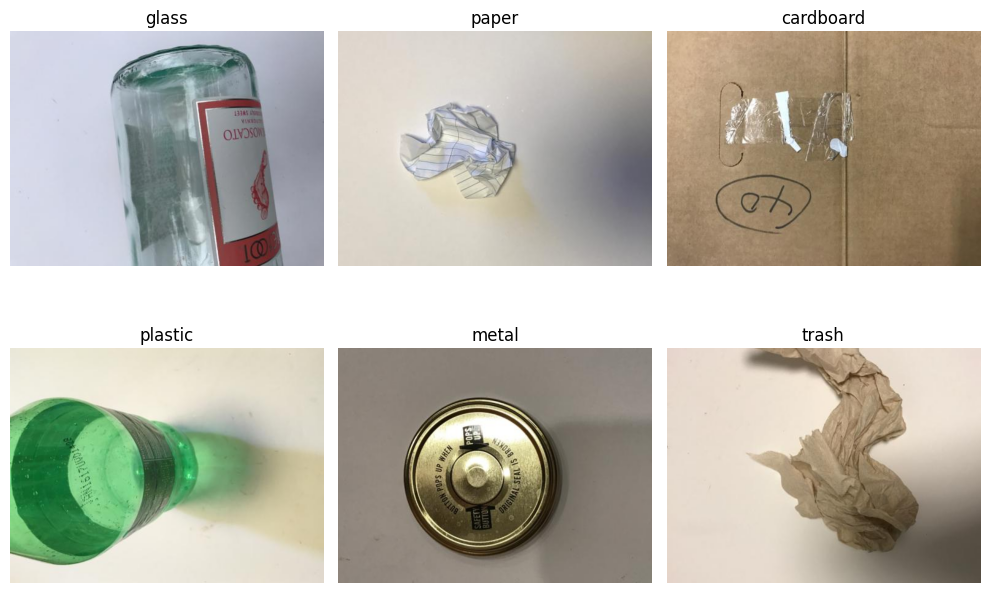

In [12]:
# Show sample images
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
sample_labels = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']
for i, label in enumerate(sample_labels):
    for path, img, l in raw_images:
        if l == label:
            ax = axes[i//3, i%3]
            ax.imshow(img)
            ax.set_title(label)
            ax.axis('off')
            break
plt.tight_layout()
plt.show()

## 4. IMPROVED Data Augmentation (More variations)

In [13]:
def augment_image(img, num_variations=3):
    augmented_images = [img] 
    for _ in range(num_variations):
        aug_img = img.copy()
        # Rotation & Flip
        if random.random() > 0.5: aug_img = aug_img.rotate(random.uniform(-20, 20))
        if random.random() > 0.5: aug_img = aug_img.transpose(Image.FLIP_LEFT_RIGHT)
        # Zoom
        if random.random() > 0.6:
            w, h = aug_img.size
            zoom = random.uniform(0.85, 0.95)
            aug_img = aug_img.resize((int(w*zoom), int(h*zoom))).resize((w, h))
        # Color Jitter
        if random.random() > 0.5: aug_img = ImageEnhance.Brightness(aug_img).enhance(random.uniform(0.7, 1.3))
        # Noise
        if random.random() > 0.8:
            arr = np.array(aug_img)
            noise = np.random.normal(0, 15, arr.shape)
            aug_img = Image.fromarray(np.clip(arr + noise, 0, 255).astype(np.uint8))
        augmented_images.append(aug_img)
    return augmented_images

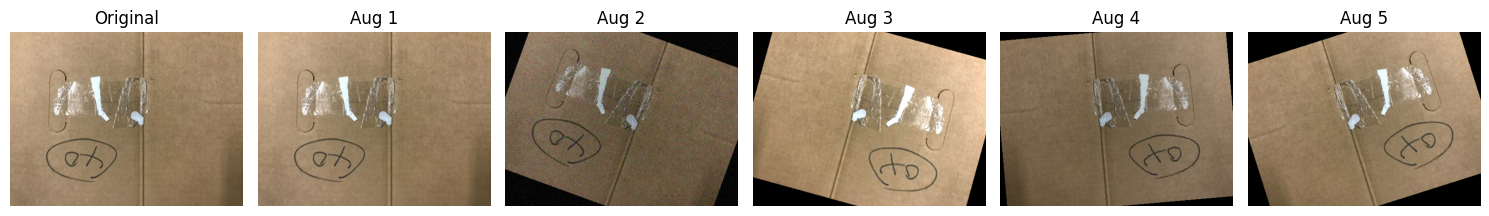

In [14]:
# Test augmentation
sample_img = raw_images[0][1]
aug_samples = augment_image(sample_img, num_variations=5)

fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i, aug_img in enumerate(aug_samples):
    axes[i].imshow(aug_img)
    axes[i].set_title(f"{'Original' if i==0 else f'Aug {i}'}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## 5. IMPROVED Feature Extraction

In [15]:
def extract_features_pipeline(img):
    img = img.resize((128, 128))
    
    # Color (RGB)
    hist = []
    for c in range(3):
        h, _ = np.histogram(np.array(img)[:,:,c], bins=32, range=(0,256))
        hist.extend(h)
    color_feat = np.array(hist) / (np.sum(hist) + 1e-7)
    
    # Texture & Shape (Gray)
    gray = np.array(img.convert("L"))
    
    # LBP
    lbp = local_binary_pattern(gray, P=16, R=2, method="uniform")
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    lbp_feat = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-7)
    
    # HOG
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(16, 16), 
                   cells_per_block=(2, 2), block_norm="L2-Hys")
    
    return np.concatenate([hog_feat, color_feat, lbp_feat])

In [16]:
# Test feature extraction
test_img = raw_images[0][1]
test_feat = extract_features_pipeline(test_img)
print(f"Feature vector size: {len(test_feat)}")

Feature vector size: 1878


## 6. Build Feature Dataset

In [17]:
# Build dataset with MORE augmentation
def build_feature_dataset(images, num_aug=5):  # Increased from 3 to 5
    X, y = [], []
    print("Extracting features (this may take a moment)...")
    
    for idx, (path, img, label) in enumerate(images):
        if idx % 200 == 0:
            print(f"Progress: {idx}/{len(images)}")
        
        for aug_img in augment_image(img, num_variations=num_aug):
            try:
                X.append(extract_features_pipeline(aug_img))
                y.append(label)
            except:
                pass
    
    return np.array(X, dtype=np.float32), np.array(y)

In [18]:
# Build the dataset
X, y = build_feature_dataset(raw_images, num_aug=5)
print(f"Dataset Shape: {X.shape}")

Extracting features (this may take a moment)...
Progress: 0/1865
Progress: 200/1865
Progress: 400/1865
Progress: 600/1865
Progress: 800/1865
Progress: 1000/1865
Progress: 1200/1865
Progress: 1400/1865
Progress: 1600/1865
Progress: 1800/1865
Dataset Shape: (11190, 1878)


## 7. Split Data

In [19]:
# Split into train and test
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {len(X_train)}, Test: {len(X_val)}")

Train: 8952, Test: 2238


## 8. Train SVM with BETTER GridSearch

In [20]:
# Create SVM pipeline with higher PCA
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.98)),  # Increased from 0.95 to 0.98
    ('svm', SVC(probability=True, class_weight='balanced'))
])
print("SVM Pipeline created")

SVM Pipeline created


In [ ]:
# LARGER parameter grid
svm_param_grid = {
    'svm__C': [0.1, 1, 10],  # More options
    'svm__gamma': ['scale', 'auto', 0.01],  # More options
    'svm__kernel': ['rbf']
}
print("Parameters:", svm_param_grid)

Parameters: {'svm__C': [0.1, 1, 10, 100], 'svm__gamma': ['scale', 'auto', 0.01, 0.001], 'svm__kernel': ['rbf']}


In [ ]:
# GridSearch for SVM with more CV folds
print("Training SVM with GridSearch...")
svm_grid = GridSearchCV(svm_pipe, svm_param_grid, cv=3, n_jobs=1, verbose=2)  # cv=5 instead of 3
svm_grid.fit(X_train, y_train)

Training SVM with GridSearch...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time= 2.3min


In [23]:
# Best SVM parameters
print(f"Best SVM Params: {svm_grid.best_params_}")
print(f"Best CV Score: {svm_grid.best_score_:.4f}")
svm_model = svm_grid.best_estimator_

Best SVM Params: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best CV Score: 0.7303


In [ ]:
# Test SVM
svm_pred = svm_model.predict(X_val)
svm_acc = accuracy_score(y_val, svm_pred)
print(f"SVM Test Accuracy: {svm_acc:.4f} ({svm_acc*100:.1f}%)")

## 9. Train k-NN with GridSearch

In [ ]:
# Create k-NN pipeline
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.98)),
    ('knn', KNeighborsClassifier())
])
print("k-NN Pipeline created")

In [ ]:
# k-NN parameter grid
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}
print("Parameters:", knn_param_grid)

In [ ]:
# GridSearch for k-NN
print("Training k-NN with GridSearch...")
knn_grid = GridSearchCV(knn_pipe, knn_param_grid, cv=5, n_jobs=-1, verbose=2)
knn_grid.fit(X_train, y_train)

In [ ]:
# Best k-NN
print(f"Best k-NN Params: {knn_grid.best_params_}")
print(f"Best CV Score: {knn_grid.best_score_:.4f}")
knn_model = knn_grid.best_estimator_

In [ ]:
# Test k-NN
knn_pred = knn_model.predict(X_val)
knn_acc = accuracy_score(y_val, knn_pred)
print(f"k-NN Test Accuracy: {knn_acc:.4f} ({knn_acc*100:.1f}%)")

## 10. Unknown Handling (Rejection)

In [ ]:
# Prediction with rejection
def predict_with_rejection(model, X, threshold=0.60):
    probs = model.predict_proba(X)
    max_probs = np.max(probs, axis=1)
    predictions = model.classes_[np.argmax(probs, axis=1)]
    
    final_preds = []
    unknown_count = 0
    
    for pred, prob in zip(predictions, max_probs):
        if prob < threshold:
            final_preds.append('unknown')
            unknown_count += 1
        else:
            final_preds.append(pred)
    
    print(f"Marked {unknown_count}/{len(X)} as Unknown")
    return np.array(final_preds)

In [ ]:
# SVM with rejection
print("SVM with Unknown Handling:")
svm_pred_rej = predict_with_rejection(svm_model, X_val, threshold=0.60)

## 11. Results

In [ ]:
print("=" * 50)
print("FINAL RESULTS")
print("=" * 50)
print(f"SVM Accuracy:  {svm_acc:.4f} ({svm_acc*100:.1f}%)")
print(f"k-NN Accuracy: {knn_acc:.4f} ({knn_acc*100:.1f}%)")
print("=" * 50)
print(f"Target: 0.85 (85%)")
if svm_acc >= 0.85:
    print("✓ SVM MEETS TARGET!")
else:
    print(f"✗ SVM needs {(0.85-svm_acc)*100:.1f}% more")
if knn_acc >= 0.85:
    print("✓ k-NN MEETS TARGET!")
print("=" * 50)

In [ ]:
# SVM Classification Report
print("SVM Classification Report:")
print(classification_report(y_val, svm_pred))

In [ ]:
# k-NN Classification Report
print("k-NN Classification Report:")
print(classification_report(y_val, knn_pred))

## 12. Confusion Matrix

In [ ]:
# Get unique labels
labels = sorted(list(set(y_val)))
print(f"Labels: {labels}")

In [ ]:
# SVM Confusion Matrix
svm_cm = confusion_matrix(y_val, svm_pred, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title(f'SVM (Accuracy: {svm_acc:.4f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
# k-NN Confusion Matrix
knn_cm = confusion_matrix(y_val, knn_pred, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.title(f'k-NN (Accuracy: {knn_acc:.4f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 13. Save Models

In [ ]:
# Save SVM
joblib.dump(svm_model, './models/svm_model.pkl')
print("SVM saved!")

In [ ]:
# Save k-NN
joblib.dump(knn_model, './models/knn_model.pkl')
print("k-NN saved!")

## 14. Test Predictions

In [ ]:
# Test on random images
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
sample_images = random.sample(raw_images, 8)

for i, (path, img, true_label) in enumerate(sample_images):
    ax = axes[i//4, i%4]
    ax.imshow(img)
    
    features = extract_features_pipeline(img).reshape(1, -1)
    pred = svm_model.predict(features)[0]
    proba = svm_model.predict_proba(features)[0]
    conf = np.max(proba)
    
    color = 'green' if pred == true_label else 'red'
    ax.set_title(f'T:{true_label}\nP:{pred} ({conf:.2f})', color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Done!

Models saved. Run `python app.py` for Flask web app.